* Author: HZQ
* Last modified: 2018/2/18


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [2]:
!mkdir -p driver
!google-drive-ocamlfuse driver
import os

os.chdir("driver/Colab Notebooks/CategoryRecom_kaggle/")
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
data	  driver   model      requirements.txt	timeline
download  LICENSE  ReadMe.md  submit		utils


In [0]:
!ls

driver	sample_data


# Main Parts

In [3]:
# Used for better debug experience
%xmode Plain
# %pdb on

Exception reporting mode: Plain


In [0]:
import datetime
import gc, sys
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

FEATS_EXCLUDED = ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0']

In [0]:
DATA_ROOT_PATH = "./data/"

data_train_path = DATA_ROOT_PATH + "data_raw/train/train.csv"
# data_train_path = DATA_ROOT_PATH + "data_raw/train/train_20190218.csv"
data_test_path = DATA_ROOT_PATH + "data_raw/test/test.csv"
data_valid_path = DATA_ROOT_PATH + "data_raw/valid/valid.csv"
data_info_path = DATA_ROOT_PATH  + "data_raw/Data_Dictionary.xlsx"
# data_merchants_path = DATA_ROOT_PATH + "data_raw/merchants.csv"
data_merchants_path = DATA_ROOT_PATH + "data_raw/merchants_20190219.csv"
data_his_trans_path = DATA_ROOT_PATH + "data_raw/historical_transactions_20190218.csv"
data_new_trans_path = DATA_ROOT_PATH + "data_raw/new_merchant_transactions.csv"

In [0]:
month_dict = \
        {1:"January", 
         2:"February", 
         3:"March", 
         4:"April", 
         5:"May", 
         6:"June", 
         7:"July", 
         8:"August", 
         9:"September", 
         10:"October", 
         11:"November", 
         12:"December"}

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

    
# rmse
def rmse(y_true, y_pred):
    
    return np.sqrt(mean_squared_error(y_true, y_pred))


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    
    gc.collect()
    sys._clear_type_cache()
    
    return df, new_columns


# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

#     end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [0]:
# Re-construct 2019/2/17: fill vacancy merchant id by other method [here](https://www.kaggle.com/raddar/merchant-id-imputations)
# def merchant_id_selected():
#     new_merchant_df = pd.read_csv(data_new_trans_path).fillna('')
#     fields = ['card_id','city_id','category_1','installments','category_3',\
#           'merchant_category_id','category_2','state_id','subsector_id']
#     new_merchant_df_part = new_merchant_df[fields + ['merchant_id']].drop_duplicates()
#     new_merchant_df_part = new_merchant_df_part.loc[new_merchant_df_part['merchant_id'] != '']  
#     # take only unique merchants for the `fields` combination
#     uq_new_merchants = new_merchant_df_part.groupby(fields)['merchant_id'].count().reset_index(name = 'n_merchants')
#     uq_new_merchants = uq_new_merchants.loc[uq_new_merchants['n_merchants'] == 1]
#     uq_new_merchants = uq_new_merchants.merge(new_merchant_df_part, on=fields)
#     uq_new_merchants.drop('n_merchants', axis=1, inplace=True)
#     # rename the merchant_id so we can join it more easily later on
#     uq_new_merchants.columns = fields + ['imputed_merchant_id']
    
#     del new_merchant_df
#     del new_merchant_df_part
#     gc.collect()
#     sys._clear_type_cache()    
    
#     return uq_new_merchants, fields


# Re-construct 2019/2/17: fill vacancy merchant id by other method [here](https://www.kaggle.com/raddar/merchant-id-imputations)
# def impute_his_merchant_id():
#     hist_reader = pd.read_csv(data_his_trans_path, chunksize=6000000)
#     hist_list = []
#     indent = 1    

#     for each_chunk in hist_reader:
#         print("[Output] expected to be end in 5 runs, this is {} run...".format(indent))
#         each_chunk = reduce_mem_usage(each_chunk)
#         hist_list.append(each_chunk)
#         indent += 1
#         gc.collect()
#     sys._clear_type_cache()        
    
#     hist_df = pd.concat(hist_list, ignore_index=True)
#     del hist_list
#     del each_chunk
#     del hist_reader
#     gc.collect()
#     sys._clear_type_cache()  
    
#     # make the actual imputation for the merchant_id field   
#     uq_new_merchants, fields = merchant_id_selected()  
#     hist_df.fillna('', inplace=True) 
#     hist_df = hist_df.merge(uq_new_merchants, on = fields, how = 'left')
#     index = (hist_df['merchant_id']=='') & (~pd.isnull(hist_df['imputed_merchant_id']))
#     hist_df.loc[index, 'merchant_id'] = hist_df.loc[index, 'imputed_merchant_id']
#     hist_df.drop(["imputed_merchant_id"], axis=1, inplace=True)
#     hist_df.to_csv(DATA_ROOT_PATH + "data_raw/historical_transactions_20190219.csv", index=False)
    
#     return hist_df


# hist_df = impute_his_merchant_id()


# Re-construct 2019/2/17: use new retrieved target values
# data_train = pd.read_csv(data_train_path)
# data_train["target"] = np.exp2(data_train["target"]) - 0.0000000001
# data_train_path = DATA_ROOT_PATH + "data_raw/train/train_20190219.csv"
# data_train.to_csv(data_train_path)


# Re-construct 2019/2/19: design aggregation for merchant.csv
def aggregate_merchants(df, df_merchant):
    '''
    INPUT:
    df -  a pandas dataframe containing data after dealing with outliers, mixed feature
    df_merchant -  a specific pandas dataframe containing data of several merchants
    
    OUTPUT:
    df_agg_merchant -  a pandas dataframe after aggregation from merchants csv file
    
    This function applly specific aggregation to INPUT.df
    '''

    df_agg_merchant = pd.merge(df, df_merchant, on="merchant_id", how="left")    
    gc.collect()
    sys._clear_type_cache()   
    
    return df_agg_merchant


# data_merchants= pd.read_csv(data_merchants_path)
# data_merchants.drop(["merchant_category_id", "city_id", "merchant_group_id"], axis=1, inplace=True)
# for each_col in ['category_1', 'category_4']:
#     data_merchants[each_col] = data_merchants[each_col].map({"Y":1, "N":0})
# data_merchants = pd.get_dummies(data_merchants, columns=["most_recent_sales_range", "most_recent_purchases_range"])
    
# print("Excecute aggregation to VARIABLE data_merchants")
# print("[Input] Aggregate specific columns below")
# agg_func = {
#         "active_months_lag12": ["mean", "max", "min"],
#         "active_months_lag3": ["mean", "max", "min"],
#         "active_months_lag6": ["mean", "max", "min"],
# #         "avg_purchases_lag12": ["mean", "max", "min"],
# #         "avg_purchases_lag3": ["mean", "max", "min"],
# #         "avg_purchases_lag6": ["mean", "max", "min"],
# #         "avg_sales_lag12": ["mean", "max", "min"],
# #         "avg_sales_lag3": ["mean", "max", "min"],
# #         "avg_sales_lag6": ["mean", "max", "min"],
#         "category_1": ["sum", "mean"],
#         "category_2": ["sum", "mean"],
#         "category_4": ["sum", "mean"],
#         "most_recent_purchases_range_A": ["mean"],        
#         "most_recent_purchases_range_B": ["mean"],    
#         "most_recent_purchases_range_C": ["mean"],    
#         "most_recent_purchases_range_D": ["mean"],    
#         "most_recent_purchases_range_E": ["mean"],    
#         "most_recent_sales_range_A": ["mean"], 
#         "most_recent_sales_range_B": ["mean"], 
#         "most_recent_sales_range_C": ["mean"], 
#         "most_recent_sales_range_D": ["mean"], 
#         "most_recent_sales_range_E": ["mean"], 
#         "numerical_1": ["sum", "mean"],
#         "numerical_2": ["sum", "mean"]
#  }

# data_merchants_agg = data_merchants.groupby(["merchant_id"]).agg(agg_func)
# data_merchants_agg.reset_index(inplace=True)
# data_merchants_agg.columns = ["_".join(col).strip() for col in data_merchants_agg.columns.values]
# del data_merchants
# gc.collect()
# sys._clear_type_cache()

# print("[Output] Store aggregated merchant data file: ")
# temp = list(data_merchants_agg.columns)
# temp[0] = "merchant_id"
# data_merchants_agg.columns = temp
# data_merchants_agg.to_csv( DATA_ROOT_PATH + "data_raw/merchants_20190219.csv", index=False)

In [0]:
# TODO 2019/2/18: MIDfc7d7969c3 = Netflix subscription prices
# TODO 2019/2/18: drop outlier rows stored in train.csv

# preprocessing train & test
def train_test(num_rows=None):

    # load csv
    train_df = pd.read_csv(data_train_path, index_col=['card_id'], nrows=num_rows)
    test_df = pd.read_csv(data_test_path, index_col=['card_id'], nrows=num_rows)

    print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))

    # outlier
    train_df['outliers'] = 0
    train_df.loc[train_df['target'] < -30, 'outliers'] = 1
    
    # set target as nan
    test_df['target'] = np.nan

    # merge
    df = train_df.append(test_df)

    del train_df, test_df
    gc.collect()

    # to datetime
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])

    # datetime features
    df['quarter'] = df['first_active_month'].dt.quarter
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    
    # Re-construct: add new elasp startoff
#     df["elasped_time_sp"] = (datetime.date(2018, 2, 1) - df['first_active_month']).dt.days
    
    df['days_feature1'] = df['elapsed_time'] * df['feature_1']
    df['days_feature2'] = df['elapsed_time'] * df['feature_2']
    df['days_feature3'] = df['elapsed_time'] * df['feature_3']

    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

    # one hot encoding
    df, cols = one_hot_encoder(df, nan_as_category=False)

    for f in ['feature_1','feature_2','feature_3']:
        order_label = df.groupby([f])['outliers'].mean()
        df[f] = df[f].map(order_label)

    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum'] / 3
    df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
    df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
    df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)
    
    df = reduce_mem_usage(df)
    gc.collect()
    sys._clear_type_cache()
    
    # Re-construct 2019/2/17: solve the KeyError: "card_id"
    df.reset_index(inplace=True)
        
    return df


# preprocessing historical transactions
def historical_transactions(num_rows=None):
    # load csv
    hist_reader = pd.read_csv(data_his_trans_path, chunksize=6000000)
    hist_list = []
    indent = 1
    for each_chunk in hist_reader:
        print("[Output] expected to be end in 5 runs, this is {} run...".format(indent))
        each_chunk = reduce_mem_usage(each_chunk)      
        hist_list.append(each_chunk)
        indent += 1
        gc.collect()
    sys._clear_type_cache()        
    
    hist_df = pd.concat(hist_list, ignore_index=True)
    del hist_list
    del each_chunk
    del hist_reader
    gc.collect()
    sys._clear_type_cache()   
    
    # fillna    
#     hist_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)     
    hist_df['category_2'].fillna(1.0, inplace=True)
    hist_df['category_3'].fillna('A', inplace=True)
    hist_df['installments'].replace(-1, np.nan, inplace=True)
    hist_df['installments'].replace(999, np.nan, inplace=True)
  
    # Re-construct 2019/2/17: create new "purchase_amount" referred [here](https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights)
    hist_df["purchase_amount"] = np.round(hist_df["purchase_amount"] / 0.00150265118 + 497.06,2)
    
    # trim
#     hist_df['purchase_amount'] = hist_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_1'] = hist_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_3'] = hist_df['category_3'].map({'A':0, 'B':1, 'C':2})

    # datetime features
    hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])
    hist_df['month'] = hist_df['purchase_date'].dt.month
    
    # Re-construct 2019/2/18: create categorical data for each month     
    hist_df["month_session"] = hist_df["month"].map(month_dict)
    hist_df = pd.get_dummies(hist_df, columns=["month_session"], drop_first=False)
    gc.collect()
    sys._clear_type_cache()
    # Or:
#     month_session_cols_list = ["month_session"+str(ind+1) for ind in range(12)]
#     le = preprocessing.LabelEncoder()
#     temp = pd.DataFrame(data=le.fit_transform(hist_df["month_session"]), columns=month_session_cols_list)
#     hist_df = pd.concat([hist_df, temp], ignore_index=True)
#     print(hist_df.isnull())
    
    hist_df['day'] = hist_df['purchase_date'].dt.day
    hist_df['hour'] = hist_df['purchase_date'].dt.hour
    hist_df['weekofyear'] = hist_df['purchase_date'].dt.weekofyear
    hist_df['weekday'] = hist_df['purchase_date'].dt.weekday
    hist_df['weekend'] = (hist_df['purchase_date'].dt.weekday >=5).astype(int)

    # additional features
    # Re-construct 2019/2/18: create new feature from "purchase_amount"
    hist_df['price'] = hist_df['purchase_amount'] / hist_df['installments']
    
    #Christmas : December 25 2017
    hist_df['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Mothers Day: May 14 2017
    hist_df['Mothers_Day_2017'] = (pd.to_datetime('2017-06-04')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #fathers day: August 13 2017
    hist_df['fathers_day_2017'] = (pd.to_datetime('2017-08-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    hist_df['Children_day_2017'] = (pd.to_datetime('2017-10-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Valentine's Day : 12th June, 2017
    hist_df['Valentine_Day_2017'] = (pd.to_datetime('2017-06-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    hist_df['Black_Friday_2017'] = (pd.to_datetime('2017-11-24') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #2018
    #Mothers Day: May 13 2018
    hist_df['Mothers_Day_2018'] = (pd.to_datetime('2018-05-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    hist_df['month_diff'] = ((datetime.datetime.today() - hist_df['purchase_date']).dt.days)//30
    hist_df['month_diff'] += hist_df['month_lag']

    # additional features 
    # Re-construct 2019/2/18: create new feature from "purchase_amount"
    hist_df['duration'] = hist_df['purchase_amount'] * hist_df['month_diff']
    hist_df['amount_month_ratio'] = hist_df['purchase_amount'] / hist_df['month_diff']
    
    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)
    gc.collect()
    sys._clear_type_cache()

    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
#     aggs['purchase_amount_new'] = ['sum','max','min','mean','var','skew']
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min']
    
    # Re-construct 2019/2/19: add month aggregation     
    aggs['month'] = ['max','min','mean','var','skew']
    aggs["month_session_April"] = ["mean"]
    aggs["month_session_August"] = ["mean"]
    aggs["month_session_December"] = ["mean"]
    aggs["month_session_February"] = ["mean"]
    aggs["month_session_January"] = ["mean"]
    aggs["month_session_July"] = ["mean"]
    aggs["month_session_June"] = ["mean"]
    aggs["month_session_March"] = ["mean"]
    aggs["month_session_May"] = ["mean"]
    aggs["month_session_November"] = ["mean"]
    aggs["month_session_October"] = ["mean"]
    aggs["month_session_September"] = ["mean"]
    
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['max','min','mean','var','skew']
    aggs['authorized_flag'] = ['mean']
    aggs['weekend'] = ['mean'] # overwrite
    aggs['weekday'] = ['mean'] # overwrite
    aggs['day'] = ['nunique', 'mean', 'min'] # overwrite
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['sum','mean','max','min','var']
#     aggs['price_new'] = ['sum','mean','max','min','var']    
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Mothers_Day_2017'] = ['mean']
    aggs['fathers_day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Valentine_Day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean','min','max','var','skew']
    aggs['amount_month_ratio']=['mean','min','max','var','skew']
#     aggs['duration_new']=['mean','min','max','var','skew']
#     aggs['amount_month_ratio_new']=['mean','min','max','var','skew']

    for col in ['category_2','category_3']:
        hist_df[col+'_mean'] = hist_df.groupby([col])['purchase_amount'].transform('mean')
        hist_df[col+'_min'] = hist_df.groupby([col])['purchase_amount'].transform('min')
        hist_df[col+'_max'] = hist_df.groupby([col])['purchase_amount'].transform('max')
        hist_df[col+'_sum'] = hist_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    hist_df = hist_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    hist_df.columns = pd.Index([e[0] + "_" + e[1] for e in hist_df.columns.tolist()])
    hist_df.columns = ['hist_'+ c for c in hist_df.columns]

    hist_df['hist_purchase_date_diff'] = (hist_df['hist_purchase_date_max'] - hist_df['hist_purchase_date_min']).dt.days
    hist_df['hist_purchase_date_average'] = hist_df['hist_purchase_date_diff'] / hist_df['hist_card_id_size']
    hist_df['hist_purchase_date_uptonow'] = (datetime.datetime.today()-hist_df['hist_purchase_date_max']).dt.days
    hist_df['hist_purchase_date_uptomin'] = (datetime.datetime.today()-hist_df['hist_purchase_date_min']).dt.days

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)
    gc.collect()
    sys._clear_type_cache()

    # Re-construct 2019/2/17: solve the KeyError: "card_id"
    hist_df.reset_index(inplace=True)
    
    return hist_df
 
    
# preprocessing new_merchant_transactions
def new_merchant_transactions(num_rows=None):
    # load csv
    new_merchant_df = pd.read_csv(data_new_trans_path, nrows=num_rows)
    gc.collect()
    sys._clear_type_cache()

    # fillna
    new_merchant_df['category_2'].fillna(1.0,inplace=True)
    new_merchant_df['category_3'].fillna('A',inplace=True)
    new_merchant_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    new_merchant_df['installments'].replace(-1, np.nan,inplace=True)
    new_merchant_df['installments'].replace(999, np.nan,inplace=True)
    
    # Re-construct 2019/2/17: create new "purchase_amount" referred [here](https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights)
    new_merchant_df["purchase_amount"] = np.round(new_merchant_df["purchase_amount"] / 0.00150265118 + 497.06,2)
    
    # trim
#     new_merchant_df['purchase_amount'] = new_merchant_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    new_merchant_df['authorized_flag'] = new_merchant_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_1'] = new_merchant_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_3'] = new_merchant_df['category_3'].map({'A':0, 'B':1, 'C':2}).astype(int)

    # datetime features
    new_merchant_df['purchase_date'] = pd.to_datetime(new_merchant_df['purchase_date'])
    new_merchant_df['month'] = new_merchant_df['purchase_date'].dt.month
    new_merchant_df['day'] = new_merchant_df['purchase_date'].dt.day
    new_merchant_df['hour'] = new_merchant_df['purchase_date'].dt.hour
    new_merchant_df['weekofyear'] = new_merchant_df['purchase_date'].dt.weekofyear
    new_merchant_df['weekday'] = new_merchant_df['purchase_date'].dt.weekday
    new_merchant_df['weekend'] = (new_merchant_df['purchase_date'].dt.weekday >=5).astype(int)

    # Re-construct 2019/2/18: create categorical data for each month     
    new_merchant_df["month_session"] = new_merchant_df["month"].map(month_dict)
    new_merchant_df = pd.get_dummies(new_merchant_df, columns=["month_session"], drop_first=False)
    gc.collect()
    sys._clear_type_cache()
    # Or:
#     month_session_cols_list = ["month_session"+str(ind+1) for ind in range(12)]
#     le = preprocessing.LabelEncoder()
#     temp = pd.DataFrame(data=le.fit_transform(new_merchant_df["month_session"]), columns=month_session_cols_list)
#     new_merchant_df = pd.concat([new_merchant_df, temp], ignore_index=True)
#     print(new_merchant_df.isnull())
    
    # additional features 
    # Re-construct 2019/2/18: create new feature from "purchase_amount"
    new_merchant_df['price'] = new_merchant_df['purchase_amount'] / new_merchant_df['installments']     
    
    #Christmas : December 25 2017
    new_merchant_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    new_merchant_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    new_merchant_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #Mothers Day: May 13 2018
    new_merchant_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    new_merchant_df['month_diff'] = ((datetime.datetime.today() - new_merchant_df['purchase_date']).dt.days)//30
    new_merchant_df['month_diff'] += new_merchant_df['month_lag']

    # additional features
    # Re-construct 2019/2/18: create new feature from "purchase_amount"
    new_merchant_df['duration'] = new_merchant_df['purchase_amount'] * new_merchant_df['month_diff']
    new_merchant_df['amount_month_ratio'] = new_merchant_df['purchase_amount'] / new_merchant_df['month_diff']
    
    # reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)
    gc.collect()
    sys._clear_type_cache()
    
    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
#     aggs['purchase_amount_new'] = ['sum','max','min','mean','var','skew']
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min']
    
    # Re-construct 2019/2/19: add month aggregation     
    aggs['month'] = ['max','min','mean','var','skew']
    aggs["month_session_April"] = ["mean"]
    aggs["month_session_August"] = ["mean"]
    aggs["month_session_December"] = ["mean"]
    aggs["month_session_February"] = ["mean"]
    aggs["month_session_January"] = ["mean"]
    aggs["month_session_July"] = ["mean"]
    aggs["month_session_June"] = ["mean"]
    aggs["month_session_March"] = ["mean"]
    aggs["month_session_May"] = ["mean"]
    aggs["month_session_November"] = ["mean"]
    aggs["month_session_October"] = ["mean"]
    aggs["month_session_September"] = ["mean"]
        
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['mean','var','skew']
    aggs['weekend'] = ['mean']
    aggs['month'] = ['mean', 'min', 'max']
    aggs['weekday'] = ['mean', 'min', 'max']
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['mean','max','min','var']
#     aggs['price_new'] = ['sum','mean','max','min','var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean','min','max','var','skew']
    aggs['amount_month_ratio']=['mean','min','max','var','skew']
#     aggs['duration_new']=['mean','min','max','var','skew']
#     aggs['amount_month_ratio_new']=['mean','min','max','var','skew']
    
    for col in ['category_2','category_3']:
        new_merchant_df[col+'_mean'] = new_merchant_df.groupby([col])['purchase_amount'].transform('mean')
        new_merchant_df[col+'_min'] = new_merchant_df.groupby([col])['purchase_amount'].transform('min')
        new_merchant_df[col+'_max'] = new_merchant_df.groupby([col])['purchase_amount'].transform('max')
        new_merchant_df[col+'_sum'] = new_merchant_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    new_merchant_df = new_merchant_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    new_merchant_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_merchant_df.columns.tolist()])
    new_merchant_df.columns = ['new_'+ c for c in new_merchant_df.columns]

    new_merchant_df['new_purchase_date_diff'] = (new_merchant_df['new_purchase_date_max'] - new_merchant_df['new_purchase_date_min']).dt.days
    new_merchant_df['new_purchase_date_average'] = new_merchant_df['new_purchase_date_diff'] / new_merchant_df['new_card_id_size']
    new_merchant_df['new_purchase_date_uptonow'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_max']).dt.days
    new_merchant_df['new_purchase_date_uptomin'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_min']).dt.days

    # reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)
    gc.collect()
    sys._clear_type_cache()

    # Re-construct 2019/2/17: solve the KeyError: "card_id"
    new_merchant_df.reset_index(inplace=True)
    
    # Re-construct 2019/2/19: add features from merchant data file
    # data_merchant_agg = pd.read_csv(data_merchants_path)
    # new_merchant_df = new_merchant_df.rename(columns={"new_merchant_id_nunique": "merchant_id"})
    # new_merchant_df = aggregate_merchants(new_merchant_df, data_merchant_agg)
    # print("Checking merge id for the next step: {} and {}".format(("merchant_id" in new_merchant_df.columns), ("merchant_id" in data_merchant_agg.columns)))
    # # reduce memory usage
    # new_merchant_df = reduce_mem_usage(new_merchant_df)
    # del  data_merchant_agg
    # del new_merchant_df["merchant_id"]
    
    return new_merchant_df


# additional features
def additional_features(df):
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

    date_features=['hist_purchase_date_max','hist_purchase_date_min',
                   'new_purchase_date_max', 'new_purchase_date_min']

    for f in date_features:
        df[f] = df[f].astype(np.int64) * 1e-9

    df['card_id_total'] = df['new_card_id_size'] + df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count'] + df['hist_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count'] / df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean'] + df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max'] + df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min'] + df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum'] / df['hist_purchase_amount_sum']
    df['month_diff_mean'] = df['new_month_diff_mean'] + df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean'] / df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_month_lag_mean'] + df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_month_lag_max'] + df['hist_month_lag_max']
    df['month_lag_min'] = df['new_month_lag_min'] + df['hist_month_lag_min']
    df['category_1_mean'] = df['new_category_1_mean'] + df['hist_category_1_mean']
    df['installments_total'] = df['new_installments_sum'] + df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean'] + df['hist_installments_mean']
    df['installments_max'] = df['new_installments_max'] + df['hist_installments_max']
    df['installments_ratio'] = df['new_installments_sum'] / df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    df['duration_mean'] = df['new_duration_mean'] + df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min'] + df['hist_duration_min']
    df['duration_max'] = df['new_duration_max'] + df['hist_duration_max']
    df['amount_month_ratio_mean']=df['new_amount_month_ratio_mean'] + df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min']=df['new_amount_month_ratio_min'] + df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max']=df['new_amount_month_ratio_max'] + df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']
    
    df = reduce_mem_usage(df)
    
    return df

In [0]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('./submit/lgbm_importances_20190219.png')
    
    return best_features

    
# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(train_df, test_df, num_folds, stratified=False, debug=False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]
    
    # Re-construct 2019/2/17: create dic to store loss
    loss_train, loss_valid = {each_fold: [] for each_fold in range(num_folds)}, {each_fold: [] for each_fold in range(num_folds)}
    
    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]
        
        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # params optimized by optuna
        params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)
                }

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits
        gc.collect()
        sys._clear_type_cache()
        
        # Re-construct 2019/2/17: store two kinds of loss        
        loss_train[n_fold].append(rmse(oof_preds[train_idx], train_y[train_idx]))
        loss_valid[n_fold].append(rmse(oof_preds[valid_idx], valid_y[valid_idx]))
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        print("Display the importance range of fold {}: ".format(n_fold+1))
        print(sorted(list(zip(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration), train_df.columns)), reverse=True))
        del reg
        gc.collect()
        
    # display importances
    best_features_df = display_importances(feature_importance_df)

    # Re-construct 2019/2/17: display final score
    print('Final RMSE : %.6f' % (rmse(train_df['target'], oof_preds)))
 
    # Re-construct 2019/2/16: evaluate modeling results
#     with timer("Evaluate modeling results"):
#         best_features_df.set_index("fold", inplace=True)
#         best_features_df.loc[2, :].sort_values(by="importance",ascending=False)
        
#         loss_train_df = pd.DataFrame(loss_train)
#         loss_valid_df = pd.DataFrame(loss_valid)
#         plt.plot(np.arange(loss_train_df.shape[1]), loss_train_df.loc[0, :].values, "bo-", np.arange(loss_valid_df.shape[1]), loss_valid_df.loc[0, :].values, "ro-");

    if not debug:
        # save submission file
        
        test_df.loc[:,'target'] = sub_preds
        test_df = test_df.reset_index()
        
        test_df[['card_id', 'target']].to_csv(submission_file_name, index=False)
        
    return best_features_df

Train samples: 201917, test samples: 123623
train & test - done in 4s
Checking merge id for the next step: True and True
new merchants - done in 449s
[Output] expected to be end in 5 runs, this is 1 run...
[Output] expected to be end in 5 runs, this is 2 run...
[Output] expected to be end in 5 runs, this is 3 run...
[Output] expected to be end in 5 runs, this is 4 run...
[Output] expected to be end in 5 runs, this is 5 run...
historical transactions - done in 2602s
additional features - done in 13s
split train & test - done in 1s
Starting LightGBM. Train shape: (201917, 255), test shape: (123623, 255)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65709	test's rmse: 3.73904
[200]	train's rmse: 3.57703	test's rmse: 3.7007
[300]	train's rmse: 3.53143	test's rmse: 3.68683
[400]	train's rmse: 3.49876	test's rmse: 3.68149
[500]	train's rmse: 3.47217	test's rmse: 3.67903
[600]	train's rmse: 3.45056	test's rmse: 3.67732
[700]	train's rmse: 3.43047	test's 

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold  1 RMSE : 3.675301
Display the importance range of fold 0: 
[(1722504.53130126, 'hist_month_session_October_mean'), (1245768.3355789185, 'hist_month_session_May_mean'), (1064626.544354558, 'new_month_session_May_mean'), (966407.1480429173, 'hist_month_lag_var'), (891204.7057487965, 'hist_day_min'), (887404.9064080715, 'hist_month_mean'), (880089.6532626152, 'hist_last_buy'), (791863.7042909265, 'installments_ratio'), (762751.5127724409, 'hist_duration_max'), (676576.1144617796, 'active_months_lag3_mean'), (577609.8118052036, 'hist_month_lag_min'), (467169.544111073, 'hist_month_diff_min'), (443051.05935025215, 'new_amount_month_ratio_max'), (374805.4403216839, 'new_amount_month_ratio_mean'), (354634.23593604565, 'new_weekday_mean'), (342989.8575987816, 'new_month_lag_var'), (303635.2739944458, 'hist_month_session_November_mean'), (302686.8853180823, 'hist_duration_skew'), (282298.26140892506, 'new_day_nunique'), (274217.3909525871, 'new_weekday_max'), (265715.14645951986, 'hist_am

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold  2 RMSE : 3.728111
Display the importance range of fold 1: 
[(2276599.1390766203, 'hist_month_session_October_mean'), (1067244.3032097816, 'new_month_session_May_mean'), (926590.0389471054, 'hist_month_mean'), (890370.7740364075, 'hist_month_lag_var'), (888424.8979854584, 'hist_day_min'), (790050.6385760307, 'hist_duration_max'), (785140.5795477033, 'hist_last_buy'), (669601.3568916321, 'installments_ratio'), (595463.9967400134, 'hist_month_lag_min'), (593603.8442139626, 'active_months_lag3_mean'), (542120.2098445892, 'hist_month_session_May_mean'), (374355.0281600952, 'hist_month_session_November_mean'), (341574.087785244, 'new_day_nunique'), (331444.6851711273, 'hist_month_diff_min'), (312014.8810316324, 'new_amount_month_ratio_mean'), (301280.33750629425, 'new_weekday_mean'), (290189.33262355626, 'new_amount_month_ratio_max'), (280710.8563671112, 'new_month_lag_var'), (246038.15583610535, 'hist_duration_min'), (233604.49867248535, 'new_month_session_June_mean'), (231250.1674041

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold  3 RMSE : 3.763877
Display the importance range of fold 2: 
[(1638290.600016594, 'hist_month_session_May_mean'), (1430481.446412623, 'hist_month_session_October_mean'), (1107739.2379490137, 'hist_month_mean'), (1029448.3407022953, 'hist_month_lag_var'), (932149.2940206528, 'hist_day_min'), (877774.5925064087, 'new_month_session_May_mean'), (821461.6855070591, 'hist_last_buy'), (793167.5781915188, 'installments_ratio'), (685752.2231470272, 'hist_duration_max'), (618641.3981406689, 'hist_month_lag_min'), (584552.968162775, 'active_months_lag3_mean'), (510517.24715961516, 'new_amount_month_ratio_max'), (438433.1250305176, 'new_month_session_June_mean'), (368073.7002023533, 'new_amount_month_ratio_mean'), (313465.4536896944, 'new_day_nunique'), (308719.51105076075, 'new_weekday_mean'), (307621.4999419078, 'hist_month_diff_min'), (266494.1660094261, 'new_month_lag_var'), (260794.00917208195, 'hist_duration_skew'), (260598.61871528625, 'hist_month_session_November_mean'), (245584.882437

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold  4 RMSE : 3.785974
Display the importance range of fold 3: 
[(1472596.110918045, 'hist_month_session_May_mean'), (1395701.2140800953, 'hist_month_session_October_mean'), (1160511.2170066833, 'new_month_session_May_mean'), (1139112.1729416847, 'hist_month_lag_var'), (1074804.5119080544, 'hist_month_mean'), (825541.6265792847, 'hist_day_min'), (785188.939174056, 'hist_last_buy'), (679773.7681510448, 'hist_duration_max'), (659378.6352808475, 'installments_ratio'), (547248.4026932716, 'hist_month_lag_min'), (522385.1782875061, 'active_months_lag3_mean'), (396984.0980974436, 'hist_month_diff_min'), (385669.5556836128, 'new_day_nunique'), (367488.66448286176, 'new_amount_month_ratio_max'), (345490.926045537, 'new_amount_month_ratio_mean'), (332417.64920425415, 'hist_month_session_November_mean'), (320394.3353238106, 'new_weekday_mean'), (320189.22305107117, 'new_month_lag_var'), (253013.0199766755, 'new_amount_month_ratio_min'), (230466.32374095917, 'hist_duration_min'), (224318.2645606

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold  5 RMSE : 3.495255
Display the importance range of fold 4: 
[(1764842.7123615742, 'hist_month_session_October_mean'), (1150076.3898992538, 'hist_month_session_May_mean'), (1086862.438967228, 'hist_month_lag_var'), (996336.1833438873, 'hist_month_mean'), (991097.2816504985, 'hist_day_min'), (952641.1520346105, 'new_month_session_May_mean'), (871832.6665142775, 'hist_duration_max'), (832717.8380793333, 'hist_last_buy'), (687473.881863594, 'installments_ratio'), (593125.9019617438, 'active_months_lag3_mean'), (552014.3694549799, 'hist_month_lag_min'), (506479.1567209959, 'new_amount_month_ratio_mean'), (458316.2144098282, 'hist_month_session_November_mean'), (379174.80119013786, 'new_day_nunique'), (369152.0006585121, 'hist_month_diff_min'), (366726.89302532375, 'new_amount_month_ratio_max'), (340350.53886413574, 'new_month_session_June_mean'), (331698.41634747386, 'new_weekday_mean'), (281586.23784554005, 'new_amount_month_ratio_var'), (272900.6797914505, 'new_month_lag_var'), (2644

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold  6 RMSE : 3.628803
Display the importance range of fold 5: 
[(1579120.150174141, 'hist_month_session_October_mean'), (1506924.9994885921, 'hist_month_session_May_mean'), (1205679.6331395432, 'hist_month_lag_var'), (1194013.8416087031, 'hist_month_mean'), (1046690.6421839893, 'new_month_session_May_mean'), (986695.8013313487, 'hist_duration_max'), (863405.9300280754, 'hist_last_buy'), (826672.2195814438, 'installments_ratio'), (735821.3037921488, 'hist_day_min'), (702194.0956139863, 'hist_month_lag_min'), (692051.9890667051, 'active_months_lag3_mean'), (598380.7346620858, 'new_amount_month_ratio_max'), (542304.8190437555, 'hist_duration_skew'), (496212.7693178654, 'hist_month_session_November_mean'), (408618.7351861745, 'new_amount_month_ratio_var'), (371695.56688348437, 'new_weekday_mean'), (371685.68542569876, 'new_amount_month_ratio_mean'), (368001.0579532981, 'hist_month_diff_min'), (312317.3174459934, 'hist_month_session_July_mean'), (311130.93367767334, 'new_month_session_Jun

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold  7 RMSE : 3.610861
Display the importance range of fold 6: 
[(1694140.6231175065, 'hist_month_session_October_mean'), (1269790.6916999817, 'hist_month_session_May_mean'), (1072047.823304236, 'hist_month_lag_var'), (1058031.8714866005, 'hist_month_mean'), (1010034.5249323845, 'new_month_session_May_mean'), (913520.8961676359, 'hist_day_min'), (802957.6321971714, 'hist_last_buy'), (757598.1939442009, 'installments_ratio'), (754814.8304042369, 'hist_duration_max'), (638155.1464066505, 'active_months_lag3_mean'), (592979.2311813831, 'hist_month_lag_min'), (391775.1117145419, 'new_amount_month_ratio_max'), (387656.34304761887, 'new_amount_month_ratio_mean'), (355240.61598062515, 'hist_month_diff_min'), (353215.2175143063, 'hist_duration_skew'), (350072.52763557434, 'new_month_lag_var'), (345202.1659119129, 'new_day_nunique'), (339414.01799196005, 'new_weekday_mean'), (311522.54857063293, 'hist_month_session_November_mean'), (303655.4106788635, 'new_month_session_June_mean'), (277740.07

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold  8 RMSE : 3.547844
Display the importance range of fold 7: 
[(1793286.1527807713, 'hist_month_session_October_mean'), (1091184.7513798475, 'hist_month_mean'), (1001825.1434650421, 'hist_month_session_May_mean'), (998673.3628292084, 'new_month_session_May_mean'), (988305.0326781273, 'hist_month_lag_var'), (851325.0039291382, 'hist_day_min'), (731370.1622345448, 'hist_last_buy'), (684479.7402148247, 'hist_duration_max'), (677411.6251699924, 'installments_ratio'), (619294.6210718155, 'active_months_lag3_mean'), (603009.4085774422, 'hist_month_lag_min'), (400875.87346601486, 'new_amount_month_ratio_mean'), (372651.61366319656, 'new_amount_month_ratio_max'), (356580.94556355476, 'new_day_nunique'), (319758.24702072144, 'new_month_session_June_mean'), (299240.2808570862, 'new_month_lag_var'), (280857.00835347176, 'new_weekday_mean'), (271567.5388805866, 'hist_month_session_November_mean'), (263074.87519836426, 'hist_month_diff_min'), (240464.94609808922, 'new_amount_month_ratio_min'), (

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold  9 RMSE : 3.694513
Display the importance range of fold 8: 
[(1704803.7143775895, 'hist_month_session_October_mean'), (1218218.880203247, 'hist_month_session_May_mean'), (1039492.153703332, 'hist_month_mean'), (992298.0607368946, 'hist_month_lag_var'), (970155.2211568058, 'new_month_session_May_mean'), (866002.7831120491, 'hist_day_min'), (806642.0658406019, 'hist_last_buy'), (767156.2863347977, 'hist_duration_max'), (739828.7881749868, 'installments_ratio'), (673766.7194776535, 'active_months_lag3_mean'), (636853.6957253218, 'hist_month_lag_min'), (434298.55779361725, 'hist_month_diff_min'), (430462.88268250227, 'new_amount_month_ratio_mean'), (425267.6335018873, 'new_amount_month_ratio_max'), (375757.5379151106, 'new_weekday_mean'), (337934.74559754133, 'new_day_nunique'), (323632.87198472023, 'hist_month_session_November_mean'), (314849.4325811267, 'hist_duration_skew'), (310546.5553789735, 'new_month_lag_var'), (305915.46861475706, 'new_amount_month_ratio_var'), (293931.341491

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold 10 RMSE : 3.546087
Display the importance range of fold 9: 
[(1848178.5920208097, 'hist_month_session_October_mean'), (1090278.3792357445, 'hist_day_min'), (1072643.5635681152, 'hist_month_lag_var'), (1025284.902987957, 'hist_month_session_May_mean'), (992504.3157844543, 'new_month_session_May_mean'), (968111.5072805882, 'hist_month_mean'), (826829.5210801959, 'hist_last_buy'), (794459.1646387577, 'hist_duration_max'), (666576.5280154645, 'installments_ratio'), (629699.6174701899, 'hist_month_lag_min'), (578157.3274121284, 'active_months_lag3_mean'), (439760.10694921017, 'new_amount_month_ratio_mean'), (380765.58769246936, 'new_amount_month_ratio_max'), (362699.75986117125, 'new_day_nunique'), (360201.9224243164, 'hist_month_session_November_mean'), (360169.4901125878, 'new_amount_month_ratio_var'), (347731.08008539677, 'hist_month_diff_min'), (334367.56889525056, 'new_weekday_mean'), (330132.91721725464, 'new_month_session_June_mean'), (296892.5438070297, 'hist_duration_skew'), (

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Fold 11 RMSE : 3.672706
Display the importance range of fold 10: 
[(1934749.600246787, 'hist_month_session_October_mean'), (1470629.2838392258, 'hist_month_session_May_mean'), (1122309.7014269084, 'hist_month_mean'), (1098034.754289627, 'hist_month_lag_var'), (1061987.4393137991, 'new_month_session_May_mean'), (946914.8125576675, 'hist_duration_max'), (921275.9292593002, 'hist_day_min'), (870442.384066999, 'hist_last_buy'), (834542.557190083, 'installments_ratio'), (701354.3536440134, 'active_months_lag3_mean'), (689468.4695852101, 'hist_month_lag_min'), (583672.8737820089, 'new_amount_month_ratio_max'), (429595.4589940384, 'hist_duration_skew'), (427224.00555860763, 'hist_month_diff_min'), (423816.5570869446, 'new_amount_month_ratio_mean'), (364218.1506752372, 'new_weekday_mean'), (351886.3251197338, 'new_hour_mean'), (337380.15344440937, 'new_month_lag_var'), (334539.67993819714, 'new_day_nunique'), (316022.6055761874, 'hist_amount_month_ratio_max'), (311643.32376503944, 'hist_purcha

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Final RMSE : 3.651033
Run LightGBM with kfold - done in 1942s
Full model run - done in 5011s


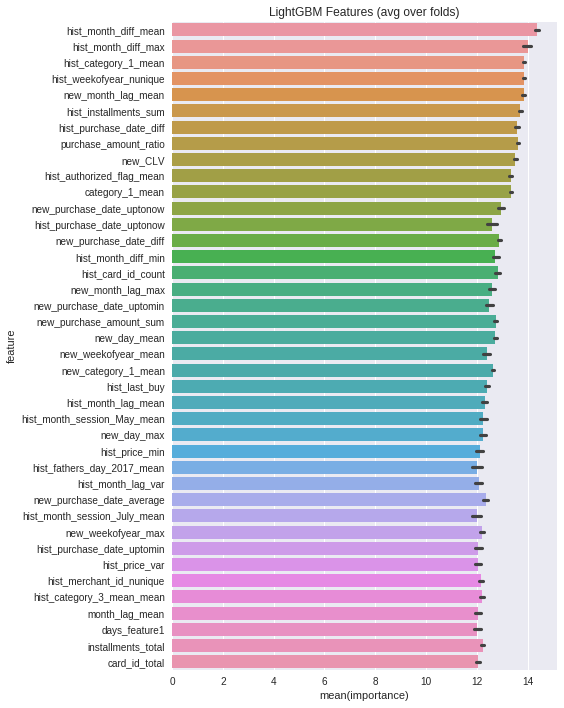

In [19]:
def main(debug=False):
    num_rows = 10000 if debug else None
    
    with timer("train & test"):
        df = train_test(num_rows)
    
    # Re-construct 2019/2/19: exchange location between two transaction data file dealing process
    with timer("new merchants"):
        df = pd.merge(df, new_merchant_transactions(num_rows), on='card_id', how='outer')    
        
    with timer("historical transactions"):
        df = pd.merge(df, historical_transactions(num_rows), on='card_id', how='outer')
        
    with timer("additional features"):
        df = additional_features(df)
        
    with timer("split train & test"):
        train_df = df[df['target'].notnull()]
        test_df = df[df['target'].isnull()]
        
#         train_df.to_csv(DATA_ROOT_PATH + "data_processed/train/data_train_20190219.csv", index=False)
#         test_df.to_csv(DATA_ROOT_PATH + "data_processed/test/data_test_20190219.csv", index=False)
        
        del df
        gc.collect()
        
    with timer("Run LightGBM with kfold"):
        best_features_df = kfold_lightgbm(train_df, test_df, num_folds=11, stratified=False, debug=debug)
      
    
if __name__ == "__main__":
    submission_file_name = './submit/submission_LGBM_hzq_20190219.csv'
    with timer("Full model run"):
        main(debug=False)

# Test Parts

In [0]:
gc.collect()
sys._clear_type_cache()

## for data

In [0]:
# calculate factorial


from functools import reduce
result = reduce(lambda x,y:x*y,range(1,num_stop+1))

### by pandas

In [0]:
df..plot.scatter/bar/...

In [0]:
df.isnull.sum().mean()  # provide a pandas series of the percentage of each row vacancy

In [0]:
df.columnA.value_counts()  # provide a pandas series of the counts for a specified column

In [0]:
df["Sample_mod"] = df["Sample"].apply(func_sample)

In [0]:
df.style.bar(subset=["Sample"], align="mid", color=["#d65f5f", "#5fba7d"])

In [0]:
month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December']
temp['purchase_month'] = pd.Categorical(temp['purchase_month'], categories = month_labels, 
                                          ordered = True)

In [0]:
df_obj = df.select_dtypes(include=['object']).copy()

In [0]:
fill_mode = lambda col: col.fillna(col.mode()[0])

new_df.apply(fill_mode, axis=0)

### by matplotlib

In [0]:
fig, axes = plt.subplots(2,sharex=True)
fig.subplots_adjust(hspace=.5)
axes[0].hist(self.data, density=True)
axes[0].set_title('Normed Histogram of Data')
axes[0].set_ylabel('Density')

axes[1].plot(x, y)
axes[1].set_title('Normal Distribution for \n Sample Mean and Sample Standard Deviation')
plt.show()


## for algorithm or package

In [0]:
import tushare as ts


data_stock = ts.get_hist_data("600519")
data_stock.isna().sum()
# data_stock.index
print(data_stock.columns, type(data_stock))

## Table Forms

Forms provide an easy way to parameterize code. From a code cell, select **Insert → Add form field**.  When you change the value in a form, the corresponding value in the code will change. 

In [0]:
#@title String fields

text = 'value' #@param {type:"string"}
dropdown = '1st option' #@param ["1st option", "2nd option", "3rd option"]
text_and_dropdown = 'value' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}

print(text)
print(dropdown)
print(text_and_dropdown)

In [0]:
#@title Raw fields

raw_input = None #@param {type:"raw"}
raw_dropdown = raw_input #@param [1, "raw_input", "False", "'string'"] {type:"raw"}

print(raw_input)
print(raw_dropdown)

In [0]:
#@title Date fields
date_input = '2018-03-22' #@param {type:"date"}

print(date_input)

In [0]:
#@title Number fields
number_input = 10.0 #@param {type:"number"}
number_slider = 0 #@param {type:"slider", min:-1, max:1, step:0.1}

integer_input = 10 #@param {type:"integer"}
integer_slider = 1 #@param {type:"slider", min:0, max:100, step:1}

print(number_input)
print(number_slider)

print(integer_input)
print(integer_slider)

In [0]:
#@title Boolean fields
boolean_checkbox = True #@param {type:"boolean"}
boolean_dropdown = True #@param ["False", "True"] {type:"raw"}

print(boolean_checkbox)
print(boolean_dropdown)

### Hiding code

You can change the view of the form by selecting **Edit → Show/hide code** or using the toolbar above the selected code cell. You can see both code and the form, just the form, or just the code.

In [0]:
#@title ## Markdown
#@markdown You can also include Markdown in forms.

#@markdown ---
#@markdown ### Enter a file path:
file_path = "" #@param {type:"string"}
#@markdown ---

